# **Model Evaluation & Testing**

In [1]:
import sys
from pathlib import Path

root_dir = str(Path.cwd().parent.absolute())
if not root_dir in sys.path:
    sys.path.insert(0, root_dir)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from src.evaluation.metrics import BLEUScore
from src.evaluation.beam_search import BeamSearchDecoder
from src.data.preprocessing import DataPreprocessor
from src.utils import load_tokenizer
from config import Config

2025-10-24 15:42:14.758983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 15:42:14.819857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 15:42:16.130533: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## **1. Load Models & Tokenizers**

In [3]:
# Load BiLSTM model
bilstm_model = tf.keras.models.load_model(
    f"{Config.ARTIFACT_PATH}/bilstm/final_bilstm_model.keras",
    compile=False
)

# Load LSTM model
lstm_model = tf.keras.models.load_model(
    f"{Config.ARTIFACT_PATH}/lstm/final_lstm_model.keras",
    compile=False
)

# Load tokenizers
tokenizer_en = load_tokenizer(f"{Config.ARTIFACT_PATH}/tokenizers/tokenizer_en.pkl")
tokenizer_vi = load_tokenizer(f"{Config.ARTIFACT_PATH}/tokenizers/tokenizer_vi.pkl")

print("Models and tokenizers loaded")

I0000 00:00:1761295337.059523  464490 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3470 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:01:00.0, compute capability: 6.1


Tokenizer loaded from .../artifacts/tokenizers/tokenizer_en.pkl
Tokenizer loaded from .../artifacts/tokenizers/tokenizer_vi.pkl
Models and tokenizers loaded


## **2. Setup Decoders**

In [4]:
bilstm_decoder = BeamSearchDecoder(
    bilstm_model, tokenizer_en, tokenizer_vi,
    Config.MAX_LENGTH_SRC, Config.MAX_LENGTH_TRG
)

lstm_decoder = BeamSearchDecoder(
    lstm_model, tokenizer_en, tokenizer_vi,
    Config.MAX_LENGTH_SRC, Config.MAX_LENGTH_TRG
)

bleu_scorer = BLEUScore(weights=[0.25, 0.25, 0.25, 0.25])

## **3. Test Translations**

In [5]:
test_sentences = [
    "Hello, how are you?",
    "I love machine learning.",
    "The weather is beautiful today.",
    "Can you help me with this problem?",
    "Thank you for your time."
]

print("="*80)
print("TRANSLATION TESTS")
print("="*80)

for text in test_sentences:
    print(f"\nInput: {text}")
    # Greedy search
    print("Greedy search:")
    # BiLSTM
    greedy_bilstm_trans = bilstm_decoder.decode_greedy(text)
    print(f"\tBiLSTM: {greedy_bilstm_trans}")

    # LSTM
    greedy_lstm_trans = lstm_decoder.decode_greedy(text)
    print(f"\tLSTM: {greedy_lstm_trans}")

    # Beam search
    print("Beam search:")
    # BiLSTM
    beam_bilstm_trans = bilstm_decoder.decode_beam_search(text)
    print(f"\tBiLSTM: {beam_bilstm_trans}")

    # LSTM
    beam_lstm_trans = lstm_decoder.decode_beam_search(text)
    print(f"\tLSTM: {beam_lstm_trans}")
    print("-"*80)

TRANSLATION TESTS

Input: Hello, how are you?
Greedy search:


2025-10-24 15:42:20.233711: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


	BiLSTM: xin chào bạn khỏe không
	LSTM: xin chào bạn
Beam search:
	BiLSTM: xin chào bạn khỏe không
	LSTM: xin chào bạn
--------------------------------------------------------------------------------

Input: I love machine learning.
Greedy search:
	BiLSTM: tôi thích học máy
	LSTM: tôi yêu máy học_tập
Beam search:
	BiLSTM: tôi thích học máy
	LSTM: tôi yêu máy học_tập
--------------------------------------------------------------------------------

Input: The weather is beautiful today.
Greedy search:
	BiLSTM: thời_tiết ngày_nay đẹp
	LSTM: thời_tiết đẹp ngày_nay
Beam search:
	BiLSTM: thời_tiết thật đẹp ngày_nay
	LSTM: thời_tiết đẹp ngày_nay
--------------------------------------------------------------------------------

Input: Can you help me with this problem?
Greedy search:
	BiLSTM: bạn có_thể giúp tôi với vấn_đề này không
	LSTM: bạn có_thể giúp tôi với vấn_đề này không
Beam search:
	BiLSTM: bạn có_thể giúp tôi với vấn_đề này không
	LSTM: bạn có_thể giúp tôi với vấn_đề này không
-----

## **4. BLEU Score Evaluation**

In [6]:
# Load test data
preprocessor = DataPreprocessor(
    max_vocab_src=Config.MAX_VOCAB_SIZE_SRC,
    max_vocab_trg=Config.MAX_VOCAB_SIZE_TRG
)

df = preprocessor.load_data(
    src_path=f"{Config.DATA_PATH}/raw/en.txt",
    trg_path=f"{Config.DATA_PATH}/raw/vi.txt",
    max_length_src=Config.MAX_LENGTH_SRC,
    max_length_trg=Config.MAX_LENGTH_TRG
)

2025-10-24 15:43:06 - src.data.preprocessing - INFO - Cleaning and expanding contractions in source data...
2025-10-24 15:43:09 - src.data.preprocessing - INFO - Filtered: 97.95% pairs kept
2025-10-24 15:43:09 - src.data.preprocessing - INFO - Memory saved: 2.1%


In [7]:
# Get test set
_, _, test_df = preprocessor.split_data(df)

In [8]:
# Evaluate on test set with Greedy Search (sample 100 for speed)
print("\n" + "="*80)
print("BLEU SCORE EVALUATION WITH GREEDY SEARCH (100 samples)")
print("="*80)

test_sample = test_df.sample(n=min(100, len(test_df)))
bilstm_greedy_bleu_scores = []
lstm_greedy_bleu_scores = []

for idx, row in test_sample.iterrows():
    en_text = row['src']
    vi_ref = row['trg'].replace('START ', '').replace(' END', '')
    
    # BiLSTM with greedy search
    bilstm_trans = bilstm_decoder.decode_greedy(en_text)
    bilstm_bleu = bleu_scorer.compute(vi_ref, bilstm_trans)
    bilstm_greedy_bleu_scores.append(bilstm_bleu)
    
    # LSTM with greedy search
    lstm_trans = lstm_decoder.decode_greedy(en_text)
    lstm_bleu = bleu_scorer.compute(vi_ref, lstm_trans)
    lstm_greedy_bleu_scores.append(lstm_bleu)

print(f"BiLSTM (Greedy) - Average BLEU: {np.mean(bilstm_greedy_bleu_scores):.2f}")
print(f"LSTM (Greedy) - Average BLEU: {np.mean(lstm_greedy_bleu_scores):.2f}")
print(f"Improvement: {np.mean(bilstm_greedy_bleu_scores) - np.mean(lstm_greedy_bleu_scores):.2f} points")


BLEU SCORE EVALUATION WITH GREEDY SEARCH (100 samples)
BiLSTM (Greedy) - Average BLEU: 32.04
LSTM (Greedy) - Average BLEU: 29.58
Improvement: 2.46 points


In [9]:
# Evaluate on test set with Beam Search
print("\n" + "="*80)
print("BLEU SCORE EVALUATION WITH BEAM SEARCH (100 samples)")
print("="*80)

bilstm_beam_bleu_scores = []
lstm_beam_bleu_scores = []

for idx, row in test_sample.iterrows():
    en_text = row['src']
    vi_ref = row['trg'].replace('START ', '').replace(' END', '')
    
    # BiLSTM with beam search
    bilstm_beam_trans = bilstm_decoder.decode_beam_search(en_text)
    bilstm_beam_bleu = bleu_scorer.compute(vi_ref, bilstm_beam_trans)
    bilstm_beam_bleu_scores.append(bilstm_beam_bleu)
    
    # LSTM with beam search
    lstm_beam_trans = lstm_decoder.decode_beam_search(en_text)
    lstm_beam_bleu = bleu_scorer.compute(vi_ref, lstm_beam_trans)
    lstm_beam_bleu_scores.append(lstm_beam_bleu)

print(f"BiLSTM (Beam Search) - Average BLEU: {np.mean(bilstm_beam_bleu_scores):.2f}")
print(f"LSTM (Beam Search) - Average BLEU: {np.mean(lstm_beam_bleu_scores):.2f}")
print(f"Improvement: {np.mean(bilstm_beam_bleu_scores) - np.mean(lstm_beam_bleu_scores):.2f} points")


BLEU SCORE EVALUATION WITH BEAM SEARCH (100 samples)
BiLSTM (Beam Search) - Average BLEU: 33.38
LSTM (Beam Search) - Average BLEU: 31.18
Improvement: 2.20 points


In [10]:
# Compare Greedy vs Beam Search
print("\n" + "="*80)
print("GREEDY VS BEAM SEARCH COMPARISON")
print("="*80)

import pandas as pd
comparison_data = {
    'Model': ['BiLSTM', 'LSTM'],
    'Greedy BLEU': [
        np.mean(bilstm_greedy_bleu_scores), 
        np.mean(lstm_greedy_bleu_scores)
    ],
    'Beam BLEU': [
        np.mean(bilstm_beam_bleu_scores), 
        np.mean(lstm_beam_bleu_scores)
    ],
    'Improvement': [
        np.mean(bilstm_beam_bleu_scores) - np.mean(bilstm_greedy_bleu_scores),
        np.mean(lstm_beam_bleu_scores) - np.mean(lstm_greedy_bleu_scores)
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n")
print(df_comparison.to_string(index=False))

avg_improvement = np.mean(comparison_data['Improvement'])
print(f"\nAverage improvement from Beam Search: {avg_improvement:.2f} BLEU points")
print(f"BiLSTM leads LSTM by {np.mean(bilstm_beam_bleu_scores) - np.mean(lstm_beam_bleu_scores):.2f} points (Beam Search)")



GREEDY VS BEAM SEARCH COMPARISON


 Model  Greedy BLEU  Beam BLEU  Improvement
BiLSTM    32.036914  33.378590     1.341676
  LSTM    29.580171  31.183464     1.603293

Average improvement from Beam Search: 1.47 BLEU points
BiLSTM leads LSTM by 2.20 points (Beam Search)


## **5. Visualization**

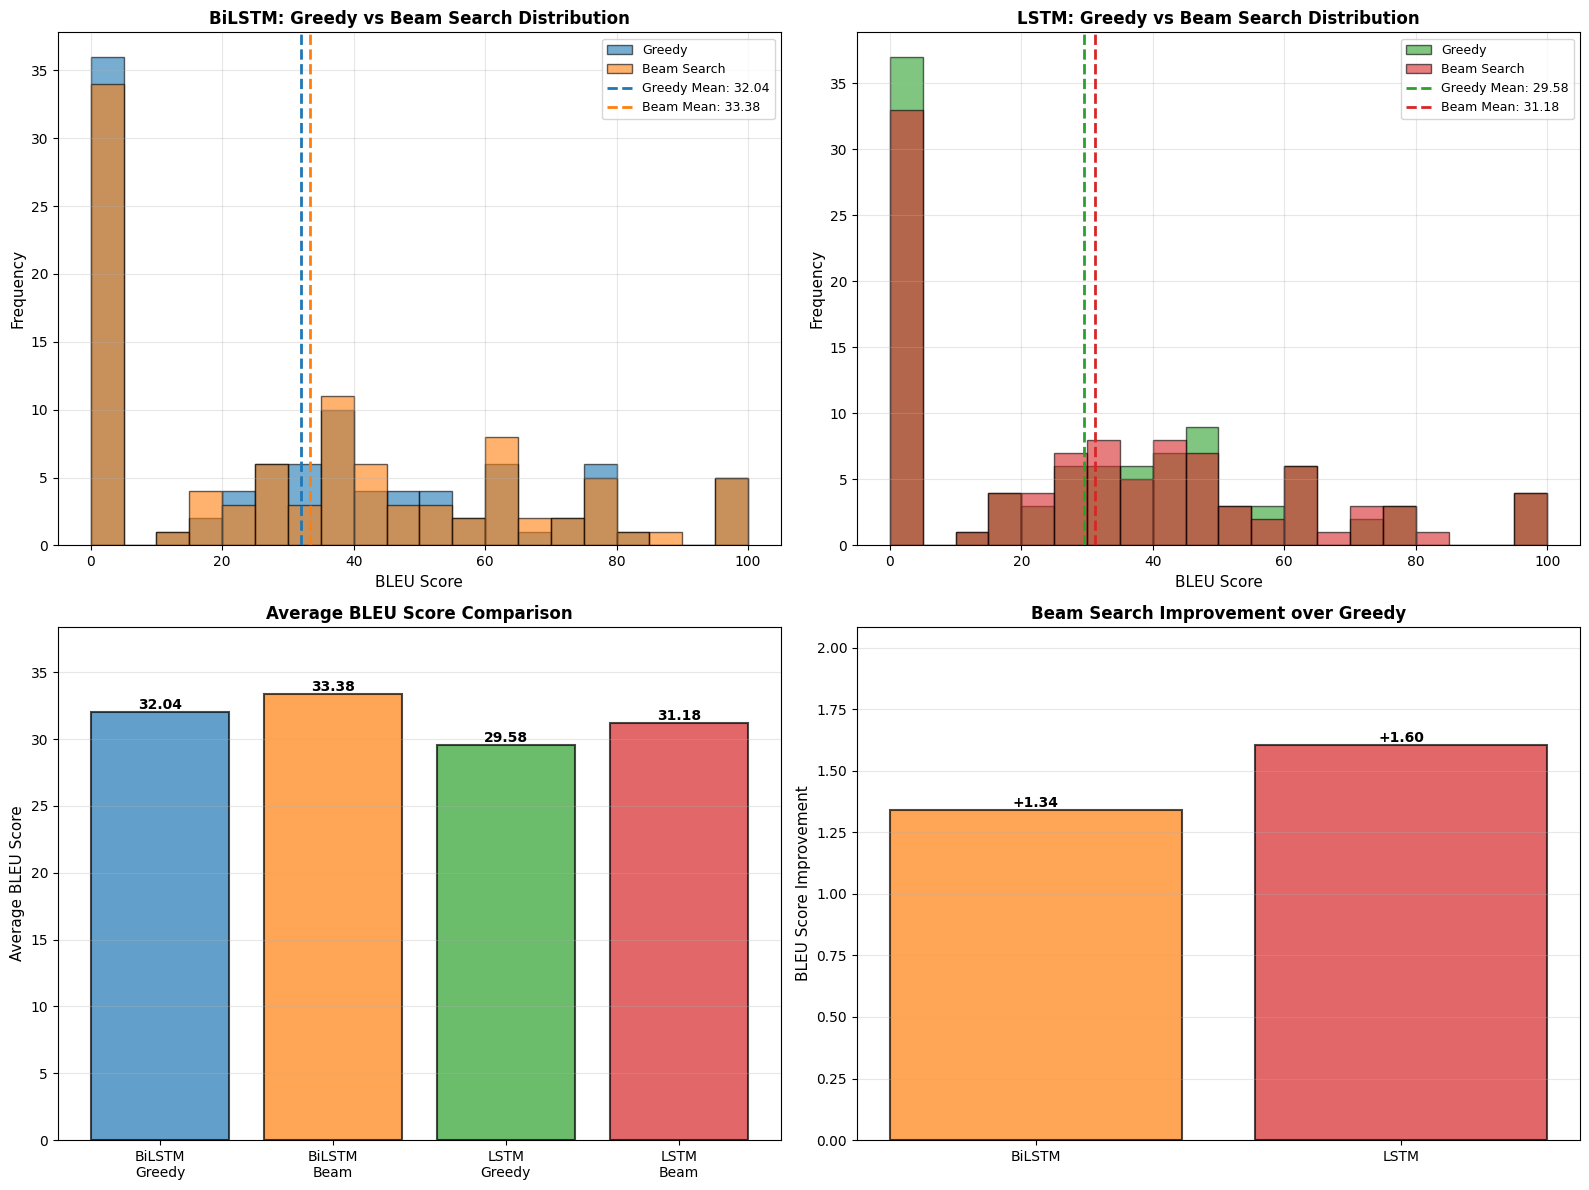


Visualization saved to assets/complete_bleu_comparison.png


In [11]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. BiLSTM: Greedy vs Beam distribution
axes[0, 0].hist(bilstm_greedy_bleu_scores, bins=20, alpha=0.6, label='Greedy', 
                color='#1f77b4', edgecolor='black')
axes[0, 0].hist(bilstm_beam_bleu_scores, bins=20, alpha=0.6, label='Beam Search', 
                color='#ff7f0e', edgecolor='black')
axes[0, 0].axvline(np.mean(bilstm_greedy_bleu_scores), color='#1f77b4', 
                   linestyle='--', linewidth=2, label=f'Greedy Mean: {np.mean(bilstm_greedy_bleu_scores):.2f}')
axes[0, 0].axvline(np.mean(bilstm_beam_bleu_scores), color='#ff7f0e', 
                   linestyle='--', linewidth=2, label=f'Beam Mean: {np.mean(bilstm_beam_bleu_scores):.2f}')
axes[0, 0].set_xlabel('BLEU Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('BiLSTM: Greedy vs Beam Search Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 2. LSTM: Greedy vs Beam distribution
axes[0, 1].hist(lstm_greedy_bleu_scores, bins=20, alpha=0.6, label='Greedy', 
                color='#2ca02c', edgecolor='black')
axes[0, 1].hist(lstm_beam_bleu_scores, bins=20, alpha=0.6, label='Beam Search', 
                color='#d62728', edgecolor='black')
axes[0, 1].axvline(np.mean(lstm_greedy_bleu_scores), color='#2ca02c', 
                   linestyle='--', linewidth=2, label=f'Greedy Mean: {np.mean(lstm_greedy_bleu_scores):.2f}')
axes[0, 1].axvline(np.mean(lstm_beam_bleu_scores), color='#d62728', 
                   linestyle='--', linewidth=2, label=f'Beam Mean: {np.mean(lstm_beam_bleu_scores):.2f}')
axes[0, 1].set_xlabel('BLEU Score', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('LSTM: Greedy vs Beam Search Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# 3. Bar comparison: All methods
models = ['BiLSTM\nGreedy', 'BiLSTM\nBeam', 'LSTM\nGreedy', 'LSTM\nBeam']
scores = [
    np.mean(bilstm_greedy_bleu_scores), 
    np.mean(bilstm_beam_bleu_scores),
    np.mean(lstm_greedy_bleu_scores), 
    np.mean(lstm_beam_bleu_scores)
]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = axes[1, 0].bar(models, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.2f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1, 0].set_ylabel('Average BLEU Score', fontsize=11)
axes[1, 0].set_title('Average BLEU Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, max(scores) * 1.15])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Improvement comparison
improvement_labels = ['BiLSTM', 'LSTM']
improvements = [
    np.mean(bilstm_beam_bleu_scores) - np.mean(bilstm_greedy_bleu_scores),
    np.mean(lstm_beam_bleu_scores) - np.mean(lstm_greedy_bleu_scores)
]
colors_imp = ['#ff7f0e', '#d62728']
bars_imp = axes[1, 1].bar(improvement_labels, improvements, color=colors_imp, 
                          alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, imp in zip(bars_imp, improvements):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'+{imp:.2f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1, 1].set_ylabel('BLEU Score Improvement', fontsize=11)
axes[1, 1].set_title('Beam Search Improvement over Greedy', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0, max(improvements) * 1.3])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{Config.ASSETS_PATH}/complete_bleu_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to assets/complete_bleu_comparison.png")

## **6. Summary Report**

In [ ]:
print("\n" + "="*80)
print("FINAL EVALUATION SUMMARY (COMPLETE)")
print("="*80)

print(f"\n{'Model':<15} {'Method':<12} {'Avg BLEU':<12} {'Min BLEU':<12} {'Max BLEU':<12}")
print("-" * 80)
print(f"{'BiLSTM':<15} {'Greedy':<12} {np.mean(bilstm_greedy_bleu_scores):<12.2f} "
      f"{np.min(bilstm_greedy_bleu_scores):<12.2f} {np.max(bilstm_greedy_bleu_scores):<12.2f}")
print(f"{'BiLSTM':<15} {'Beam Search':<12} {np.mean(bilstm_beam_bleu_scores):<12.2f} "
      f"{np.min(bilstm_beam_bleu_scores):<12.2f} {np.max(bilstm_beam_bleu_scores):<12.2f}")
print(f"{'LSTM':<15} {'Greedy':<12} {np.mean(lstm_greedy_bleu_scores):<12.2f} "
      f"{np.min(lstm_greedy_bleu_scores):<12.2f} {np.max(lstm_greedy_bleu_scores):<12.2f}")
print(f"{'LSTM':<15} {'Beam Search':<12} {np.mean(lstm_beam_bleu_scores):<12.2f} "
      f"{np.min(lstm_beam_bleu_scores):<12.2f} {np.max(lstm_beam_bleu_scores):<12.2f}")

print("\n" + "-" * 80)
print("KEY FINDINGS:")
print("-" * 80)
print(f"1. BiLSTM vs LSTM (Greedy):       BiLSTM leads by {np.mean(bilstm_greedy_bleu_scores) - np.mean(lstm_greedy_bleu_scores):.2f} points")
print(f"2. BiLSTM vs LSTM (Beam Search):  BiLSTM leads by {np.mean(bilstm_beam_bleu_scores) - np.mean(lstm_beam_bleu_scores):.2f} points")
print(f"3. Beam vs Greedy (BiLSTM):       +{np.mean(bilstm_beam_bleu_scores) - np.mean(bilstm_greedy_bleu_scores):.2f} points improvement")
print(f"4. Beam vs Greedy (LSTM):         +{np.mean(lstm_beam_bleu_scores) - np.mean(lstm_greedy_bleu_scores):.2f} points improvement")
print(f"5. Average Beam Search gain:      +{avg_improvement:.2f} points")

print("\n" + "-" * 80)
print("MODEL PARAMETERS:")
print("-" * 80)
print(f"BiLSTM: {bilstm_model.count_params():,} parameters")
print(f"LSTM:   {lstm_model.count_params():,} parameters")

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print(f"BiLSTM consistently outperforms LSTM across both decoding methods")
print(f"Beam Search improves translation quality by ~{avg_improvement:.2f} BLEU points on average")
print(f" Best performance: BiLSTM + Beam Search ({np.mean(bilstm_beam_bleu_scores):.2f} BLEU)")
print("="*80)


FINAL EVALUATION SUMMARY (COMPLETE)

Model           Method       Avg BLEU     Min BLEU     Max BLEU    
--------------------------------------------------------------------------------
BiLSTM          Greedy       32.04        0.00         100.00      
BiLSTM          Beam Search  33.38        0.00         100.00      
LSTM            Greedy       29.58        0.00         100.00      
LSTM            Beam Search  31.18        0.00         100.00      

--------------------------------------------------------------------------------
KEY FINDINGS:
--------------------------------------------------------------------------------
1. BiLSTM vs LSTM (Greedy):       BiLSTM leads by 2.46 points
2. BiLSTM vs LSTM (Beam Search):  BiLSTM leads by 2.20 points
3. Beam vs Greedy (BiLSTM):       +1.34 points improvement
4. Beam vs Greedy (LSTM):         +1.60 points improvement
5. Average Beam Search gain:      +1.47 points

--------------------------------------------------------------------------